# Testing Dale's Sentinel-2 Cloud Mask

In [1]:
%matplotlib inline

import sys
import datacube
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import s2cloudmask

sys.path.append('../Scripts')
from deafrica_plotting import rgb
from deafrica_datahandling import load_ard 

In [2]:
lat, lon = 6.448191, 3.207363 #lagos
buffer = 0.075

# Create a reusable query
query = {
    'x': (lon - buffer, lon + buffer),
    'y':  (lat + buffer, lat - buffer),
    'time': ('2019-01-01', '2019-02-06'),
    'resolution': (-20, 20),
    'measurements': ['blue', 'green', 'red', 'red_edge_1', 'red_edge_2',
                     'red_edge_3', 'nir_1','nir_2', 'swir_1', 'swir_2'],
}

In [3]:
dc = datacube.Datacube(app='S2_cloud_mask')

# Load available data
ds = dc.load(product='s2_l2a',
              group_by='solar_day',
              output_crs='epsg:6933',
              **query)
# Print output data
print(ds)

<xarray.Dataset>
Dimensions:      (time: 8, x: 483, y: 635)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T10:19:00 ... 2019-02-05T10:19:06
  * y            (y) float64 8.273e+05 8.272e+05 ... 8.146e+05 8.146e+05
  * x            (x) float64 3.046e+05 3.047e+05 ... 3.143e+05 3.143e+05
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 517 824 699 417 738 ... 1260 1276 1260 1276
    green        (time, y, x) uint16 855 1344 1138 849 ... 1234 1244 1250 1246
    red          (time, y, x) uint16 800 1172 861 668 1028 ... 961 939 940 943
    red_edge_1   (time, y, x) uint16 1276 1360 1442 1324 ... 968 976 982 965
    red_edge_2   (time, y, x) uint16 1744 2034 2401 2981 ... 906 904 901 899
    red_edge_3   (time, y, x) uint16 2095 2122 2965 3292 ... 907 907 901 889
    nir_1        (time, y, x) uint16 2263 2082 2984 3681 ... 846 845 835 841
    nir_2        (time, y, x) uint16 2199 2446 3134 3477 ... 836 826 821 841
    swir_1       (time, y, x) 

### Plot the unmasked data

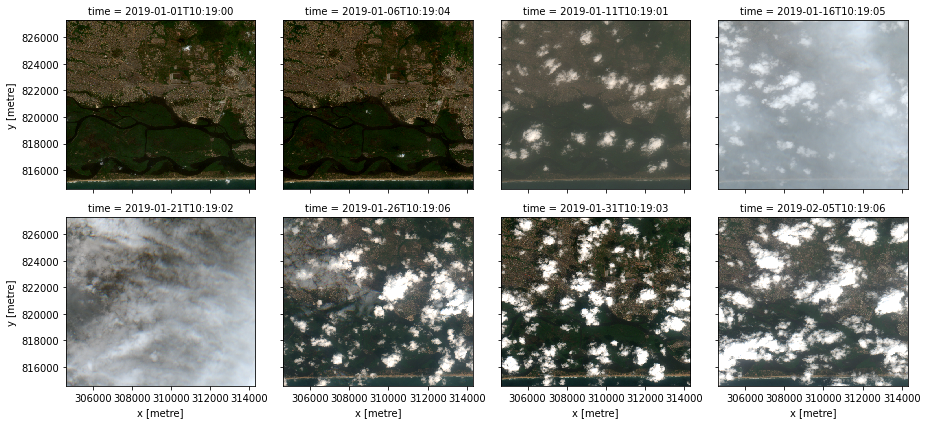

In [8]:
rgb_bands = ['red', 'green', 'blue']

(ds[rgb_bands] ** 0.5).to_array().plot.imshow(
    robust=True, col='time', col_wrap=4)

### Run Dale's Classifier

In [9]:
# Rearrange band order to (y, x, bands, time)
data = ds.transpose("y", "x", "time").to_array().values
data = np.moveaxis(data, 0, -2)

#normalise data
data = data.astype(np.float32)
data[(data.data == 0)] = np.nan
data = data.clip(0, 10000)
data /= 10000.

In [10]:
%%time
# Run classifier
# mask_array = s2cloudmask.cloud_mask(data, model='spectral')
mask_array = s2cloudmask.cloud_probs(data, model='spectral') < 0.20

# Convert output to xarray
mask_da = xr.DataArray(mask_array, dims=['y', 'x', 'time'], 
                       coords={'x': ds.x, 'y': ds.y, 'time': ds.time})

CPU times: user 2min 1s, sys: 762 ms, total: 2min 1s
Wall time: 1min 4s


### Plot masked data

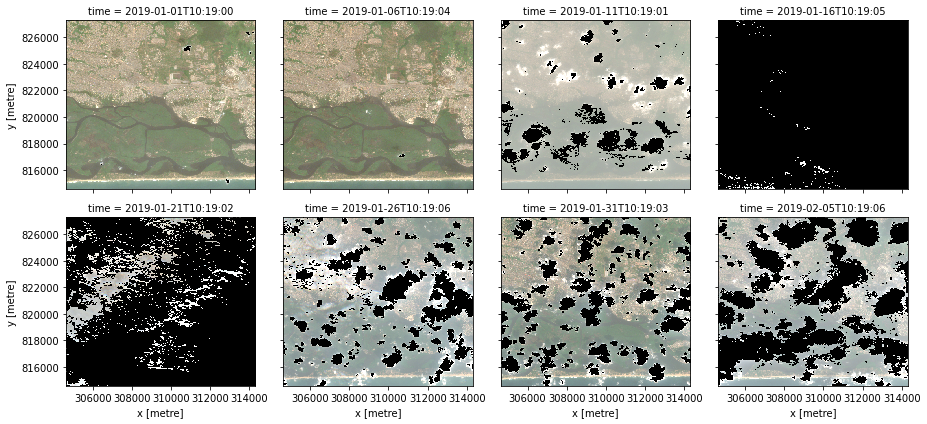

In [11]:
(ds[rgb_bands] ** 0.5).where(mask_da, 0).to_array().plot.imshow(
    robust=True, col='time', col_wrap=4)

## ESA's Scene Classifiier (SCL)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 8 time steps


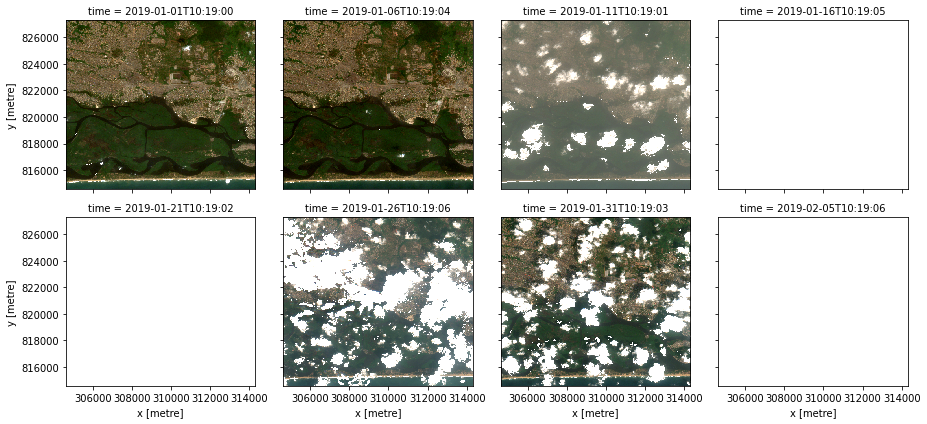

In [14]:
# Load available data
ds_scl = load_ard(dc=dc, 
              products=['s2_l2a'],
              group_by='solar_day',
              output_crs='epsg:6933', 
              **query)

(ds_scl[rgb_bands] ** 0.5).to_array().plot.imshow(
    robust=True, col='time', col_wrap=4)